# [Hw06] Clustering
Jeong Ji Hoon 2016010980

### Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 1. Load Iris Dataset

In [2]:
## Load Iris Data set
NUM_FEATURE = 4 # Number of Features in each sample

#Dataset Download
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',header=None)
dataset = df.values

#Iris name to integer codes
iris_names = np.unique(dataset[:,NUM_FEATURE])
for i,name in enumerate(iris_names):
    dataset[np.where(dataset[:,NUM_FEATURE] == name),NUM_FEATURE] = i

X = dataset[:,:NUM_FEATURE].astype(float)
y = dataset[:,NUM_FEATURE].astype(int)

X = StandardScaler().fit_transform(X)

featureLabels = ['sepal length', 'sepal width', 'petal length', 'petal width']

# 2. K-means

## 2a & b. Implement K-mean algorithm & k-means++ initialization method

In [3]:
# Class definition
class KMeans_my(object):
    # KMean Algorithm을 구현. 
    def __init__(self, n_clusters=3, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0):
        self.n_clusters = n_clusters
        self.init = init
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def fit(self, X):
        # 주어진 조건으로 fit 만 진행하는 함수.

        # 코드 간결성을 위해 변수 지정.
        datasize = np.shape(X)[0]
        datadimension = np.shape(X)[1]

        # 총 n_init 번 돌려야 함.
        # 매 iteration에서 centroid 값과 errorscore 값을 저장.
        centroidset = np.zeros([self.n_init,self.n_clusters,datadimension])
        errorscore = np.zeros(self.n_init)
        for iterations in range(self.n_init):
            # initial centroid 지정
            centroid = self.initialize(X)
            meandistance = 0
            for run in range(self.max_iter):
                # 현재 centroid를 기반으로 모든 sample 들의 euclidean distance를 구함.
                distances = np.zeros([datasize,self.n_clusters])
                for i in range(self.n_clusters):
                    diff = np.tile(centroid[i,:],[datasize,1]) - X
                    distances[:,i] = np.sum(diff**2,1)**0.5

                # 이렇게 구한 euclidean distance를 기반으로 가장 가까운 centroid 라벨을 부여.
                labels = np.argmin(distances, 1)

                # meandistance가 tolerance보다 작으면 관두고
                meandistance = np.mean(np.min(distances,1))
                if  meandistance< self.tol:
                    break
                # 여전히 크면 새로운 라벨을 기반으로 새로운 centroid를 선택함.
                else:
                    for i in range(self.n_clusters):
                        centroid[i,:] = np.mean(X[labels==i,:],0)
            # 다 돌린뒤 centroid 와 score를 저장.
            centroidset[iterations,:,:] = centroid
            errorscore[iterations] = meandistance
        # 가장 성능이 좋았던 centroid를 선택.
        self.centroid = centroidset[np.argmin(errorscore),:]
        return self

    def fit_predict(self, X):
        # 주어진 조건으로 fit과 함께 해당하는 sample의 label을 출력하는 함수.

        # do fit
        self.fit(X)

        # variables
        n_clusters = self.n_clusters
        centroid = self.centroid
        datasize = np.shape(X)[0]

        # 모든 sample 들의 euclidean distance를 구함.
        distances = np.zeros([datasize, n_clusters])
        for i in range(n_clusters):
            diff = np.tile(centroid[i, :], [datasize, 1]) - X
            distances[:, i] = np.sum(diff ** 2, 1) ** 0.5

        # distances를 기반으로 가장 가까운 centroid 라벨을 부여.
        labels = np.argmin(distances, 1)
        return labels

    def initialize(self,X):
        # 초기 centroid를 지정하는 함수.

        #rgen 여기에서 초기화.
        rgen = np.random.RandomState(self.random_state)

        # 코드 간결성을 위해 변수 지정
        datasize = np.shape(X)[0]
        datadimension = np.shape(X)[1]

        # 걍 아무거나 랜덤으로 정함.
        if self.init == 'random':
            centroid = X[rgen.permutation(datasize)[0:self.n_clusters], :]
        # k-mean 플플 알고리즘 적용.
        elif self.init == 'k-means++':
            # centroid 값 넣을 변수 생성
            centroid = np.zeros([self.n_clusters,datadimension])
            # 첫 centroid는 아무거나 정함
            centroidindex = rgen.permutation(datasize)[0]
            centroid[0,:] = X[centroidindex, :]
            # 선택한 sample은 X에서 제외.
            newX = np.delete(X,centroidindex,0)

            # 나머지 centroid를 정하는 알고리즘 시작
            for i in range(self.n_clusters - 1):
                # 모든 sample 들의 euclidean distance를 구함.
                distances = np.zeros([datasize -1 -i, i + 1])
                for j in range(i+1):
                    diff = np.tile(centroid[j, :], [datasize -1 -i, 1]) - newX
                    distances[:, j] = np.sum(diff ** 2, 1) ** 0.5

                # 이 distance 중에서 최소 값을 기준으로 다음 centroid로 뽑힐 확률을 계산.
                probabilities = np.min(distances, 1) / np.sum(np.min(distances,1))
                # [0,1] 범위를 distance 값을 사용해서 나눔.
                randomrange = np.cumsum(probabilities)
                # rand(1) 값보다 처음으로 큰 randomrange 값을 index로 고름.
                newindex = np.argmax(randomrange > rgen.rand(1))

                # centroid 에 넣기.
                centroid[i+1,:] = newX[newindex,:]

                # 넣은 sample은 빼기
                newX = np.delete(newX,newindex,0)
        # 그런 옵션은 없습니다 고객님.
        else:
            raise ValueError(self.init + ' is not appropriate parameter!')
        return centroid

## 2c. Run k-means

### 2c-1. Cluster numbers

Text(0.5,1,'Cluster 5')

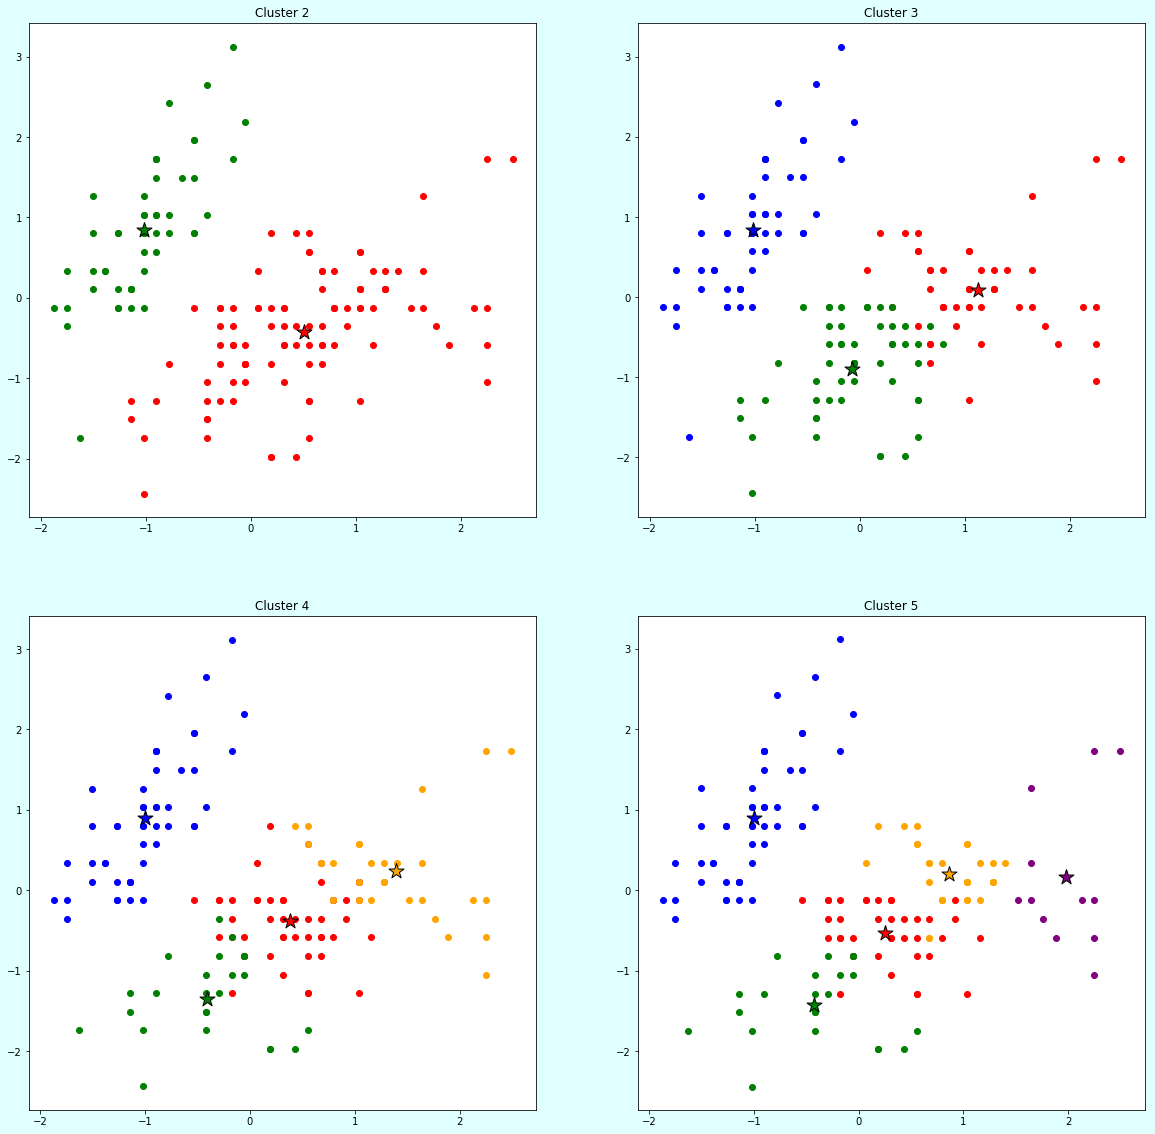

In [4]:
fig = plt.figure(figsize=(20,20))
fig.patch.set_facecolor('lightcyan')

ax = fig.subplots(2,2)

# Cluster 2
km = KMeans_my(n_clusters=2, init='k-means++',n_init=10, max_iter=100)
ys = km.fit_predict(X)
ax[0,0].scatter(X[ys==0,0],X[ys==0,1],c='r')
ax[0,0].scatter(X[ys==1,0],X[ys==1,1],c='g')
ax[0,0].scatter(km.centroid[0,0],km.centroid[0,1],s=250,c='r',marker='*',edgecolors='k')
ax[0,0].scatter(km.centroid[1,0],km.centroid[1,1],s=250,c='g',marker='*',edgecolors='k')
ax[0,0].set_title('Cluster 2')

# Cluster 3
km = KMeans_my(n_clusters=3, init='k-means++',n_init=10, max_iter=100)
ys = km.fit_predict(X)
ax[0,1].scatter(X[ys==0,0],X[ys==0,1],c='r')
ax[0,1].scatter(X[ys==1,0],X[ys==1,1],c='g')
ax[0,1].scatter(X[ys==2,0],X[ys==2,1],c='b')
ax[0,1].scatter(km.centroid[0,0],km.centroid[0,1],s=250,c='r',marker='*',edgecolors='k')
ax[0,1].scatter(km.centroid[1,0],km.centroid[1,1],s=250,c='g',marker='*',edgecolors='k')
ax[0,1].scatter(km.centroid[2,0],km.centroid[2,1],s=250,c='b',marker='*',edgecolors='k')
ax[0,1].set_title('Cluster 3')

# Cluster 4
km = KMeans_my(n_clusters=4, init='k-means++',n_init=10, max_iter=100)
ys = km.fit_predict(X)
ax[1,0].scatter(X[ys==0,0],X[ys==0,1],c='r')
ax[1,0].scatter(X[ys==1,0],X[ys==1,1],c='g')
ax[1,0].scatter(X[ys==2,0],X[ys==2,1],c='b')
ax[1,0].scatter(X[ys==3,0],X[ys==3,1],c='orange')
ax[1,0].scatter(km.centroid[0,0],km.centroid[0,1],s=250,c='r',marker='*',edgecolors='k')
ax[1,0].scatter(km.centroid[1,0],km.centroid[1,1],s=250,c='g',marker='*',edgecolors='k')
ax[1,0].scatter(km.centroid[2,0],km.centroid[2,1],s=250,c='b',marker='*',edgecolors='k')
ax[1,0].scatter(km.centroid[3,0],km.centroid[3,1],s=250,c='orange',marker='*',edgecolors='k')
ax[1,0].set_title('Cluster 4')

# Cluster 5
km = KMeans_my(n_clusters=5, init='k-means++',n_init=10, max_iter=100)
ys = km.fit_predict(X)
ax[1,1].scatter(X[ys==0,0],X[ys==0,1],c='r')
ax[1,1].scatter(X[ys==1,0],X[ys==1,1],c='g')
ax[1,1].scatter(X[ys==2,0],X[ys==2,1],c='b')
ax[1,1].scatter(X[ys==3,0],X[ys==3,1],c='orange')
ax[1,1].scatter(X[ys==4,0],X[ys==4,1],c='purple')
ax[1,1].scatter(km.centroid[0,0],km.centroid[0,1],s=250,c='r',marker='*',edgecolors='k')
ax[1,1].scatter(km.centroid[1,0],km.centroid[1,1],s=250,c='g',marker='*',edgecolors='k')
ax[1,1].scatter(km.centroid[2,0],km.centroid[2,1],s=250,c='b',marker='*',edgecolors='k')
ax[1,1].scatter(km.centroid[3,0],km.centroid[3,1],s=250,c='orange',marker='*',edgecolors='k')
ax[1,1].scatter(km.centroid[4,0],km.centroid[4,1],s=250,c='purple',marker='*',edgecolors='k')
ax[1,1].set_title('Cluster 5')


### Observation
- 이 이후의 모든 plot은 iris data set의 첫 두 feature를 각각 x축, y축으로 사용해서 plotting 하였다.
- 원래 Class가 3인 것을 생각했을 때 Cluster의 수가 4 이상으로 늘어나면 cluster가 확실히 구분이 되지 않는다.

### 2c-2. initialization

Text(0.5,1,'k-means++')

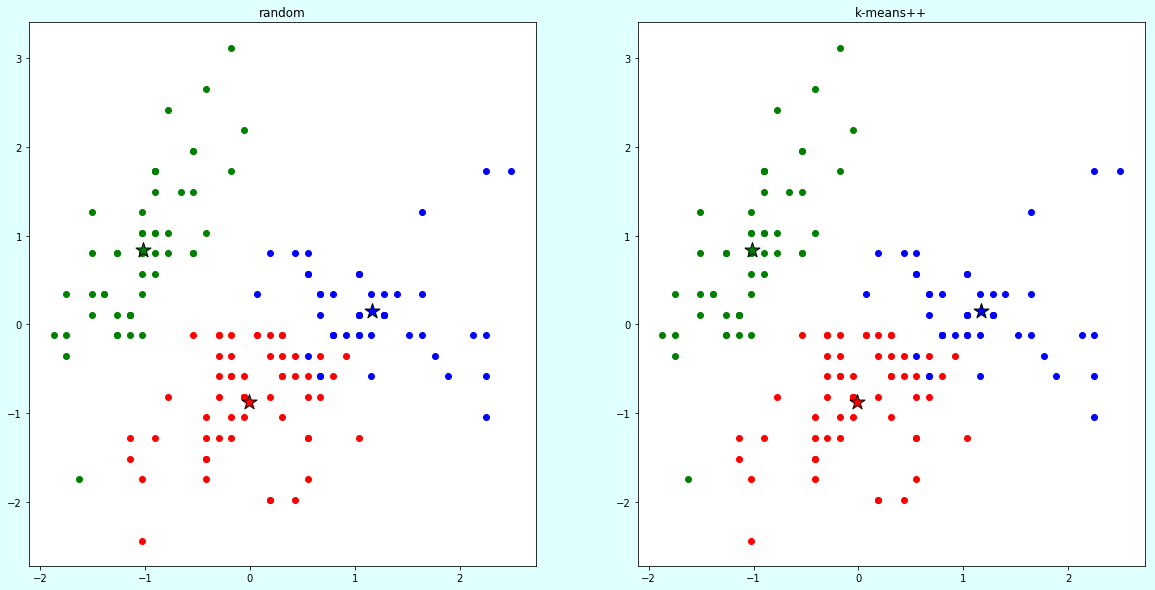

In [5]:
fig = plt.figure(figsize=(20,10))
fig.patch.set_facecolor('lightcyan')

ax = fig.subplots(1,2)

# random
km = KMeans_my(n_clusters=3, init='random',n_init=10, max_iter=100, random_state=100)
ys = km.fit_predict(X)
ax[0].scatter(X[ys==0,0],X[ys==0,1],c='r')
ax[0].scatter(X[ys==1,0],X[ys==1,1],c='g')
ax[0].scatter(X[ys==2,0],X[ys==2,1],c='b')
ax[0].scatter(km.centroid[0,0],km.centroid[0,1],s=250,c='r',marker='*',edgecolors='k')
ax[0].scatter(km.centroid[1,0],km.centroid[1,1],s=250,c='g',marker='*',edgecolors='k')
ax[0].scatter(km.centroid[2,0],km.centroid[2,1],s=250,c='b',marker='*',edgecolors='k')
ax[0].set_title('random')

# k-means++
km = KMeans_my(n_clusters=3, init='k-means++',n_init=10, max_iter=100, random_state=100)
ys = km.fit_predict(X)
ax[1].scatter(X[ys==0,0],X[ys==0,1],c='r')
ax[1].scatter(X[ys==1,0],X[ys==1,1],c='g')
ax[1].scatter(X[ys==2,0],X[ys==2,1],c='b')
ax[1].scatter(km.centroid[0,0],km.centroid[0,1],s=250,c='r',marker='*',edgecolors='k')
ax[1].scatter(km.centroid[1,0],km.centroid[1,1],s=250,c='g',marker='*',edgecolors='k')
ax[1].scatter(km.centroid[2,0],km.centroid[2,1],s=250,c='b',marker='*',edgecolors='k')
ax[1].set_title('k-means++')


### Observation
- 다른 차원의 데이터에서는 어떻게 나왔는지 모르겠지만, 적어도 iris data의 첫 두 feature를 사용한 그래프에서는 두 방법 모두 비슷한 결과가 나타났다.
- 비교적 iris data가 잘 clustering이 되고 iteration 수가 많아서 두 초기화 방법에서 비슷하게 잘 clustering이 되는 것이 아닌가 싶다.

### 2c-3. scikit-learn

Text(0.5,1,'Scikit-learn  K-mean')

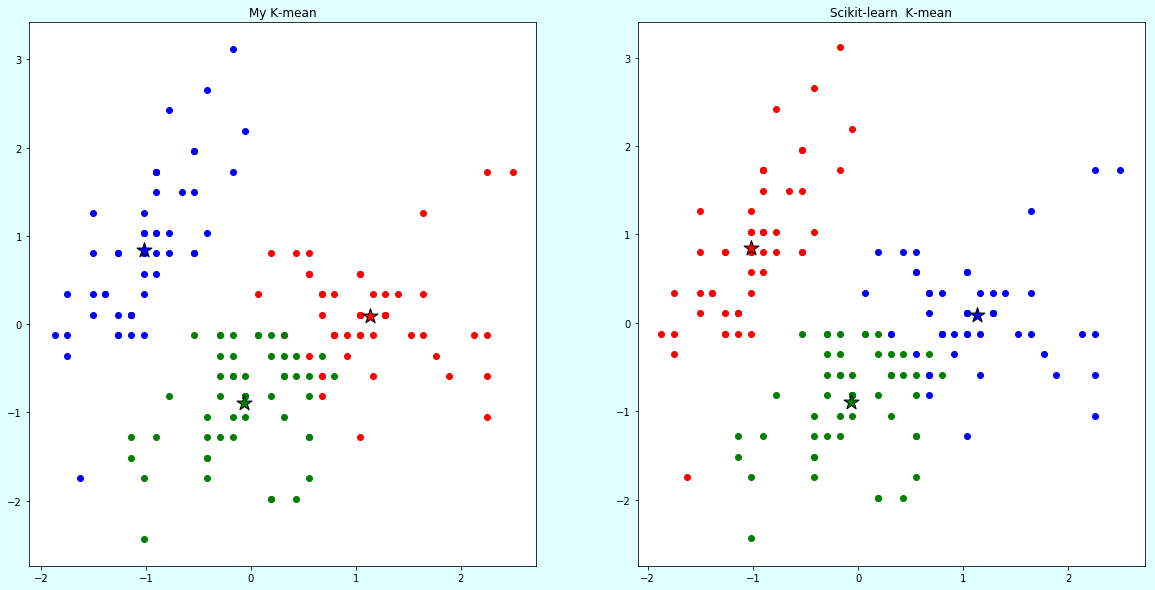

In [6]:
from sklearn.cluster import KMeans

fig = plt.figure(figsize=(20,10))
fig.patch.set_facecolor('lightcyan')

ax = fig.subplots(1,2)

# my
km = KMeans_my(n_clusters=3, init='k-means++',n_init=10, max_iter=100)
ys = km.fit_predict(X)
ax[0].scatter(X[ys==0,0],X[ys==0,1],c='r')
ax[0].scatter(X[ys==1,0],X[ys==1,1],c='g')
ax[0].scatter(X[ys==2,0],X[ys==2,1],c='b')
ax[0].scatter(km.centroid[0,0],km.centroid[0,1],s=250,c='r',marker='*',edgecolors='k')
ax[0].scatter(km.centroid[1,0],km.centroid[1,1],s=250,c='g',marker='*',edgecolors='k')
ax[0].scatter(km.centroid[2,0],km.centroid[2,1],s=250,c='b',marker='*',edgecolors='k')
ax[0].set_title('My K-mean')

# scikit-learn
km = KMeans(n_clusters=3, init='k-means++',n_init=10, max_iter=100)
ys = km.fit_predict(X)
ax[1].scatter(X[ys==0,0],X[ys==0,1],c='r')
ax[1].scatter(X[ys==1,0],X[ys==1,1],c='g')
ax[1].scatter(X[ys==2,0],X[ys==2,1],c='b')
ax[1].scatter(km.cluster_centers_[0,0],km.cluster_centers_[0,1],s=250,c='r',marker='*',edgecolors='k')
ax[1].scatter(km.cluster_centers_[1,0],km.cluster_centers_[1,1],s=250,c='g',marker='*',edgecolors='k')
ax[1].scatter(km.cluster_centers_[2,0],km.cluster_centers_[2,1],s=250,c='b',marker='*',edgecolors='k')
ax[1].set_title('Scikit-learn  K-mean')

### Observation
- 다른 차원의 데이터에서는 어떻게 나왔는지 모르겠지만, 직접 구현한 kmean과 scikit learn의 kmean의 결과는 유사하게 나타났다.
- 이 역시 비교적 iris data가 잘 clustering이 되고 iteration 수가 많아서 두 초기화 방법에서 비슷하게 잘 clustering이 되는 것이 아닌가 싶다.

# 3. Fuzzy C-means

## 3a. Implement the FCM

In [7]:

class FCM(object):
    # Fuzzy C KMean Algorithm을 구현.
    def __init__(self, n_clusters=3, fuzzy_coef_m = 2, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0):
        self.n_clusters = n_clusters
        self.fuzzy_coef_m = fuzzy_coef_m
        self.init = init
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def fit(self, X):
        # 주어진 조건으로 fit 만 진행하는 함수.

        # 코드 간결성을 위해 변수 지정.
        datasize = np.shape(X)[0]
        datadimension = np.shape(X)[1]

        # 총 n_init 번 돌려야 함.
        # 매 iteration에서 centroid 값과 errorscore 값을 저장.
        centroidset = np.zeros([self.n_init,self.n_clusters,datadimension])
        errorscore = np.zeros(self.n_init)
        for iterations in range(self.n_init):
            # initial centroid 지정
            centroid = self.initialize(X)
            meandistance = 0
            for run in range(self.max_iter):
                # 현재 centroid를 기반으로 모든 sample 들의 euclidean distance를 구함.
                distances = np.zeros([datasize,self.n_clusters])
                for i in range(self.n_clusters):
                    diff = np.tile(centroid[i,:],[datasize,1]) - X
                    distances[:,i] = np.sum(diff**2,1)**0.5

                # 이렇게 구한 euclidean distance를 기반으로 w 값을 구함.
                labels = np.zeros([datasize,self.n_clusters])
                
                # 처음 centroid로 뽑힌 sample들은 centroid와의 거리가 0이라 이후 계산에 문제가 생김. 작은 값을 더해줌.
                distances = distances + 0.000001 
                for i in range(self.n_clusters):
                    labels[:,i] = np.sum(
                        (np.tile(distances[:,i].reshape([-1,1]),[1,self.n_clusters]) / distances) ** (2/(self.fuzzy_coef_m-1))
                    ,1)

                labels = labels ** -1

                # meandistance가 tolerance보다 작으면 관두고
                meandistance = np.mean(np.mean(distances,1))
                if  meandistance< self.tol:
                    break
                # 여전히 크면 새로운 라벨을 기반으로 새로운 centroid를 선택함.
                else:
                    for i in range(self.n_clusters):
                        centroid[i, :] = np.sum(X * np.tile((labels[:, i]).reshape([-1, 1]), [1, datadimension]),0) / np.sum((labels[:, i]))
            # 다 돌린뒤 centroid 와 score를 저장.
            centroidset[iterations,:,:] = centroid
            errorscore[iterations] = meandistance
        # 가장 성능이 좋았던 centroid를 선택.
        self.centroid = centroidset[np.argmin(errorscore),:]
        return self

    def fit_predict(self, X):
        # 주어진 조건으로 fit과 함께 해당하는 sample의 label을 출력하는 함수.

        # do fit
        self.fit(X)

        # variables
        n_clusters = self.n_clusters
        centroid = self.centroid
        datasize = np.shape(X)[0]

        # 현재 centroid를 기반으로 모든 sample 들의 euclidean distance를 구함.
        distances = np.zeros([datasize, self.n_clusters])
        for i in range(self.n_clusters):
            diff = np.tile(centroid[i, :], [datasize, 1]) - X
            distances[:, i] = np.sum(diff ** 2, 1) ** 0.5

            # 이렇게 구한 euclidean distance를 기반으로 w 값을 구함.
            labels = np.zeros([datasize, self.n_clusters])
            # 처음 centroid로 뽑힌 sample들은 centroid와의 거리가 0이라 이후 계산에 문제가 생김. 작은 값을 더해줌.
            distances = distances + 0.000001
            for i in range(self.n_clusters):
                labels[:, i] = np.sum(
                    (np.tile(distances[:, i].reshape([-1, 1]), [1, self.n_clusters]) / distances) ** (2 / (self.fuzzy_coef_m - 1))
                    , 1)

            labels = labels ** -1
        return labels

    def initialize(self,X):
        # 초기 centroid를 지정하는 함수.

        #rgen 여기에서 초기화.
        rgen = np.random.RandomState(self.random_state)

        # 코드 간결성을 위해 변수 지정
        datasize = np.shape(X)[0]
        datadimension = np.shape(X)[1]

        # 걍 아무거나 랜덤으로 정함.
        if self.init == 'random':
            centroid = X[rgen.permutation(datasize)[0:self.n_clusters], :]
        # k-mean 플플 알고리즘 적용.
        elif self.init == 'k-means++':
            # centroid 값 넣을 변수 생성
            centroid = np.zeros([self.n_clusters,datadimension])
            # 첫 centroid는 아무거나 정함
            centroidindex = rgen.permutation(datasize)[0]
            centroid[0,:] = X[centroidindex, :]
            # 선택한 sample은 X에서 제외.
            newX = np.delete(X,centroidindex,0)

            # 나머지 centroid를 정하는 알고리즘 시작
            for i in range(self.n_clusters - 1):
                # 모든 sample 들의 euclidean distance를 구함.
                distances = np.zeros([datasize -1 -i, i + 1])
                for j in range(i+1):
                    diff = np.tile(centroid[j, :], [datasize -1 -i, 1]) - newX
                    distances[:, j] = np.sum(diff ** 2, 1) ** 0.5

                # 이 distance 중에서 최소 값을 기준으로 다음 centroid로 뽑힐 확률을 계산.
                probabilities = np.min(distances, 1) / np.sum(np.min(distances,1))
                # [0,1] 범위를 distance 값을 사용해서 나눔.
                randomrange = np.cumsum(probabilities)
                # rand(1) 값보다 처음으로 큰 randomrange 값을 index로 고름.
                newindex = np.argmax(randomrange > rgen.rand(1))

                # centroid 에 넣기.
                centroid[i+1,:] = newX[newindex,:]

                # 넣은 sample은 빼기
                newX = np.delete(newX,newindex,0)
        # 그런 옵션은 없습니다 고객님.
        else:
            raise ValueError(self.init + ' is not appropriate parameter!')
        return centroid


## 3b. Cluster Number Variation

Text(0.5,1,'Cluster 5')

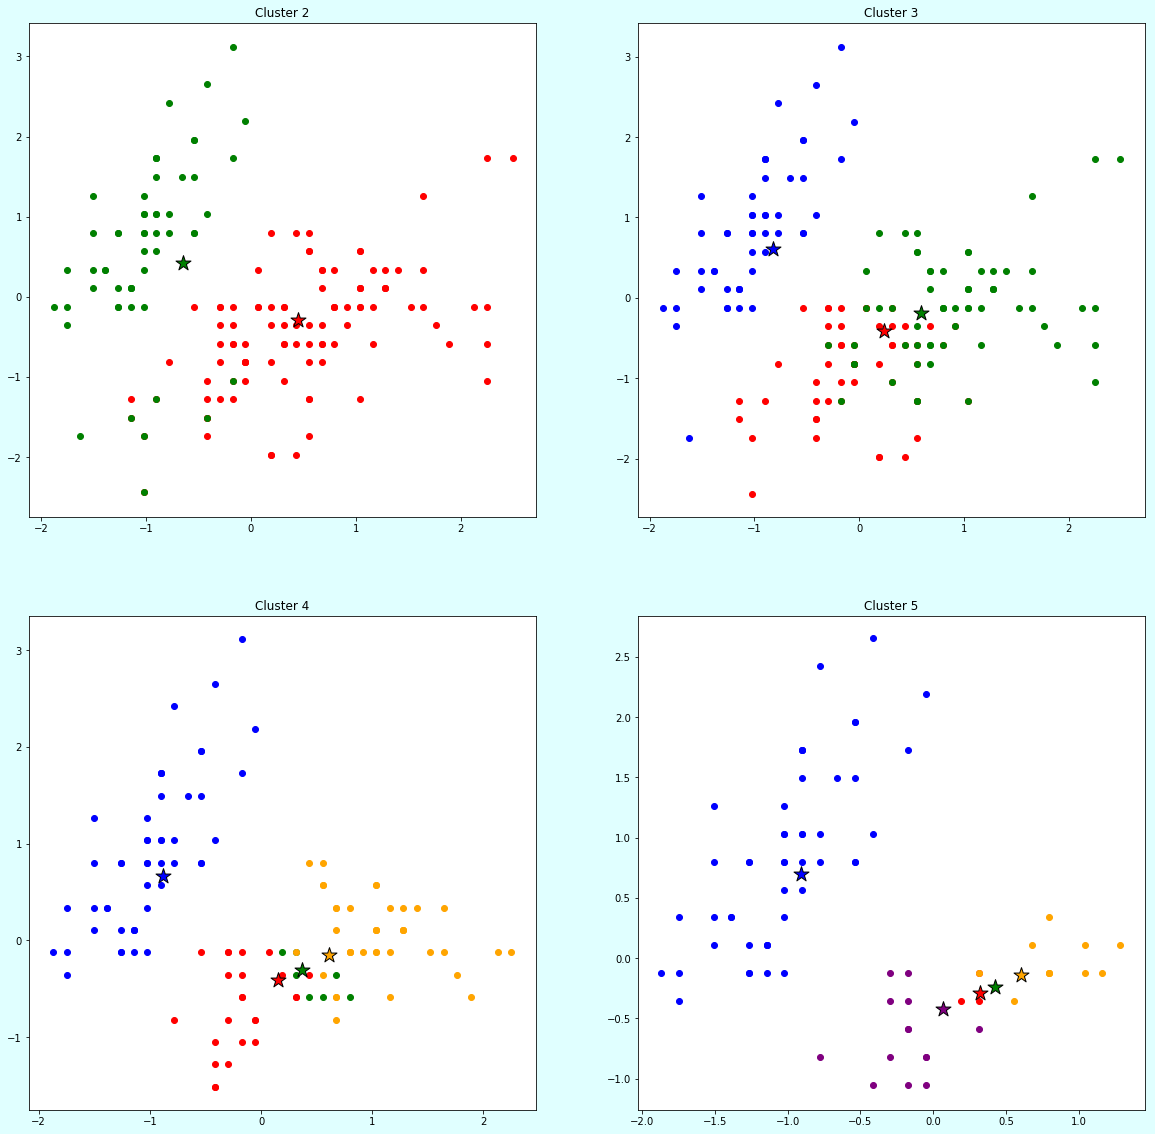

In [8]:
fig = plt.figure(figsize=(20,20))
fig.patch.set_facecolor('lightcyan')

ax = fig.subplots(2,2)

# Cluster 2
fcm = FCM(n_clusters=2,init='k-means++',random_state=10,fuzzy_coef_m=2,tol=1e-10)
labels = fcm.fit_predict(X)
ax[0,0].scatter(X[labels[:,0]>0.4,0],X[labels[:,0]>0.4,1],c='r')
ax[0,0].scatter(X[labels[:,1]>0.4,0],X[labels[:,1]>0.4,1],c='g')
ax[0,0].scatter(fcm.centroid[0,0],fcm.centroid[0,1],s=250,c='r',marker='*',edgecolors='k')
ax[0,0].scatter(fcm.centroid[1,0],fcm.centroid[1,1],s=250,c='g',marker='*',edgecolors='k')
ax[0,0].set_title('Cluster 2')

# Cluster 3
fcm = FCM(n_clusters=3,init='k-means++',random_state=10,fuzzy_coef_m=2,tol=1e-10)
labels = fcm.fit_predict(X)
ax[0,1].scatter(X[labels[:,0]>0.4,0],X[labels[:,0]>0.4,1],c='r')
ax[0,1].scatter(X[labels[:,1]>0.4,0],X[labels[:,1]>0.4,1],c='g')
ax[0,1].scatter(X[labels[:,2]>0.4,0],X[labels[:,2]>0.4,1],c='b')
ax[0,1].scatter(fcm.centroid[0,0],fcm.centroid[0,1],s=250,c='r',marker='*',edgecolors='k')
ax[0,1].scatter(fcm.centroid[1,0],fcm.centroid[1,1],s=250,c='g',marker='*',edgecolors='k')
ax[0,1].scatter(fcm.centroid[2,0],fcm.centroid[2,1],s=250,c='b',marker='*',edgecolors='k')
ax[0,1].set_title('Cluster 3')

# Cluster 4
fcm = FCM(n_clusters=4,init='k-means++',random_state=10,fuzzy_coef_m=2,tol=1e-10)
labels = fcm.fit_predict(X)
ax[1,0].scatter(X[labels[:,0]>0.4,0],X[labels[:,0]>0.4,1],c='r')
ax[1,0].scatter(X[labels[:,1]>0.4,0],X[labels[:,1]>0.4,1],c='g')
ax[1,0].scatter(X[labels[:,2]>0.4,0],X[labels[:,2]>0.4,1],c='b')
ax[1,0].scatter(X[labels[:,3]>0.4,0],X[labels[:,3]>0.4,1],c='orange')
ax[1,0].scatter(fcm.centroid[0,0],fcm.centroid[0,1],s=250,c='r',marker='*',edgecolors='k')
ax[1,0].scatter(fcm.centroid[1,0],fcm.centroid[1,1],s=250,c='g',marker='*',edgecolors='k')
ax[1,0].scatter(fcm.centroid[2,0],fcm.centroid[2,1],s=250,c='b',marker='*',edgecolors='k')
ax[1,0].scatter(fcm.centroid[3,0],fcm.centroid[3,1],s=250,c='orange',marker='*',edgecolors='k')
ax[1,0].set_title('Cluster 4')

# Cluster 5
fcm = FCM(n_clusters=5,init='k-means++',random_state=10,fuzzy_coef_m=2,tol=1e-10)
labels = fcm.fit_predict(X)
ax[1,1].scatter(X[labels[:,0]>0.4,0],X[labels[:,0]>0.4,1],c='r')
ax[1,1].scatter(X[labels[:,1]>0.4,0],X[labels[:,1]>0.4,1],c='g')
ax[1,1].scatter(X[labels[:,2]>0.4,0],X[labels[:,2]>0.4,1],c='b')
ax[1,1].scatter(X[labels[:,3]>0.4,0],X[labels[:,3]>0.4,1],c='orange')
ax[1,1].scatter(X[labels[:,4]>0.4,0],X[labels[:,4]>0.4,1],c='purple')
ax[1,1].scatter(fcm.centroid[0,0],fcm.centroid[0,1],s=250,c='r',marker='*',edgecolors='k')
ax[1,1].scatter(fcm.centroid[1,0],fcm.centroid[1,1],s=250,c='g',marker='*',edgecolors='k')
ax[1,1].scatter(fcm.centroid[2,0],fcm.centroid[2,1],s=250,c='b',marker='*',edgecolors='k')
ax[1,1].scatter(fcm.centroid[3,0],fcm.centroid[3,1],s=250,c='orange',marker='*',edgecolors='k')
ax[1,1].scatter(fcm.centroid[4,0],fcm.centroid[4,1],s=250,c='purple',marker='*',edgecolors='k')
ax[1,1].set_title('Cluster 5')


In [9]:
sampleIndex = np.random.permutation(150)[0]
print('Sample {0} : {1:.3f} {2:.3f} {3:.3f} {4:.3f} {5:.3f}'.format(sampleIndex, labels[sampleIndex,0], labels[sampleIndex,1], labels[sampleIndex,2], labels[sampleIndex,3], labels[sampleIndex,4]))

Sample 109 : 0.216 0.243 0.069 0.306 0.166


In [10]:
print(np.sum(labels,1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


### Observation
- kmean과 유사하지만 조금더 noise 하게 결과가 나왔다.
- cluster 수가 5를 넘어가면 특정 cluster에 해당하는 sample수가 극단적으로 줄어들고 의미가 없는 것이 한눈에 보인다.
- hard clustering과 다르게 label 변수에 지정된 것처럼 각 sample별로 각 cluster에 해당할 확률 값을 알 수 있으며, 
- 이들의 합이 1이 됨을 np.sum 함수의 결과값을 통해서 알 수 있다.

# Cf. Elbow method & Silhouette method

Text(0,0.5,'Distortion')

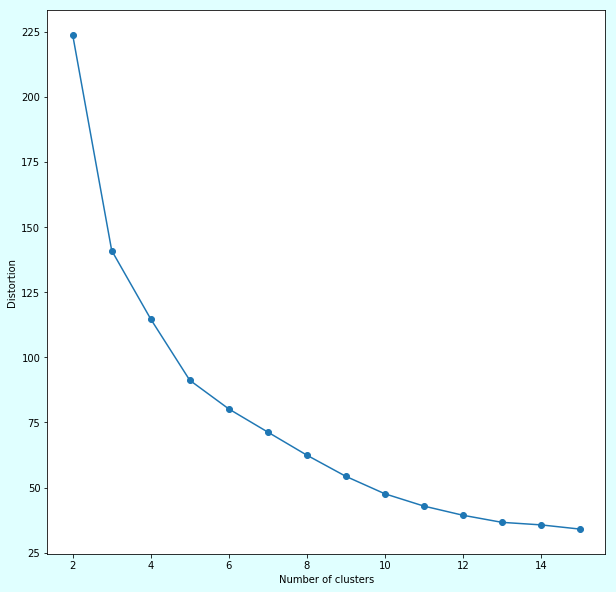

In [11]:
fig = plt.figure(figsize=(10,10))
fig.patch.set_facecolor('lightcyan')
# Elbow
distortions = []
for i in range(2, 16):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(2, 16), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')



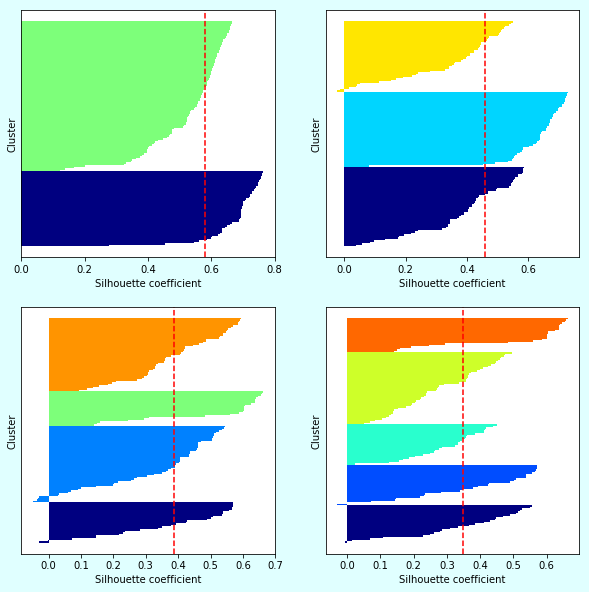

In [12]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples

fig = plt.figure(figsize=(10,10))
fig.patch.set_facecolor('lightcyan')

ax = fig.subplots(2,2)

# Elbow

for loc in range(4):
    km = KMeans(n_clusters=loc+2, init='k-means++', n_init=10, max_iter=100, random_state=0)
    y_km = km.fit_predict(X)
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        ax[int(loc/2),np.remainder(loc,2)].barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    ax[int(loc/2),np.remainder(loc,2)].axvline(silhouette_avg, color="red", linestyle="--")
    ax[int(loc/2),np.remainder(loc,2)].set_yticks([])
    ax[int(loc/2),np.remainder(loc,2)].set_ylabel('Cluster')
    ax[int(loc/2),np.remainder(loc,2)].set_xlabel('Silhouette coefficient')



### Observation
- cluster의 수가 2->3으로 갈 때 elbow plot에서 distortion이 급격하게 감소함을 알 수 있다.
- elbow plot을 보면 4나 5가 적절한 cluster 갯수로 보인다.
- 그러나 silhouette plot을 보면 Cluster가 3일때 가장 적절한 cluster 갯수가 보이고, (당연하다. 3class sample을 50개씩 집어넣었으니.)
- cluster 수가 2일때 가장 silhouette coefficient가 높게 관찰된다.